## ResFPN Classifier Tutorial - COVIDx

by *Ming Ming Zhang*

In [1]:
import tensorflow as tf
print('TF Version:', tf.__version__)
#print('GPUs:', len(tf.config.list_physical_devices('GPU')))

import numpy as np
import matplotlib.pyplot as plt
import os, sys, time
import concurrent.futures as cf
from skimage.io import imread, imsave
from skimage.color import gray2rgb

TF Version: 2.3.1


In [2]:
# python files directory
PY_DIR = #'directory/to/python/files'
sys.path.append(PY_DIR)

# dataset directory
DATASET_DIR = #'directory/to/covidx'
sys.path.append(DATASET_DIR)

### Preprocess Data

In [3]:
def move_imgs(split_txt_path, split='train'):
    with open(split_txt_path, 'r') as file:
        info = file.readlines()
    
    imgs_list, classes_list = [], []
    for an_info in info:
        imgs_list.append(an_info.split()[1])
        classes_list.append(an_info.split()[2])

    last_dir_path = os.path.join(DATASET_DIR, split)
    classes = np.unique(np.array(classes_list))
    for class_name in classes: 
        path = os.path.join(last_dir_path, class_name)
        if not os.path.exists(path):
            os.mkdir(path)
            
    t1 = time.time()
    with cf.ThreadPoolExecutor() as executor:
        for idx in range(len(imgs_list)):
            from_file = os.path.join(last_dir_path, imgs_list[idx])
            to_file = os.path.join(last_dir_path, classes_list[idx], imgs_list[idx])
            executor.submit(os.rename, from_file, to_file)
    t2 = time.time()
    print('Processed %s %.1f seconds' % (split, t2-t1))

In [4]:
split_txt_path = os.path.join(DATASET_DIR, 'train_split.txt')
move_imgs(split_txt_path, split='train')

Processed train 118.2 seconds


In [5]:
split_txt_path = os.path.join(DATASET_DIR, 'test_split.txt')
move_imgs(split_txt_path, split='test')

Processed test 0.1 seconds


In [6]:
TRAIN_DIR = os.path.join(DATASET_DIR, 'train')
TRAIN_NUM_IMGS = {}

print('-----Training Set Info-----')
for class_name in os.listdir(TRAIN_DIR):
    imgs_list = os.listdir(os.path.join(TRAIN_DIR, class_name))
    num_imgs = len(imgs_list)
    TRAIN_NUM_IMGS[class_name] = num_imgs
    print('%s: %d images' % (class_name, num_imgs))

-----Training Set Info-----
COVID-19: 489 images
normal: 7966 images
pneumonia: 5463 images


In [7]:
TEST_DIR = os.path.join(DATASET_DIR, 'test')

print('-----Test Set Info-----')
for class_name in os.listdir(TEST_DIR):
    imgs_list = os.listdir(os.path.join(TEST_DIR, class_name))
    print('%s: %d images' % (class_name, len(imgs_list)))

-----Test Set Info-----
COVID-19: 100 images
normal: 885 images
pneumonia: 594 images


In [8]:
CLASS_NAMES = os.listdir(TRAIN_DIR)
print('classes:', CLASS_NAMES)

classes: ['COVID-19', 'normal', 'pneumonia']


#### Subsample Training Data

In [9]:
ratio = TRAIN_NUM_IMGS['COVID-19']/(
    sum([TRAIN_NUM_IMGS[class_name] for class_name in CLASS_NAMES]))
print('COVID-19 ratio in training set:', ratio)

COVID-19 ratio in training set: 0.035134358384825405


In [10]:
def subsample_train_imgs(n):
    t1 = time.time()
    for class_name in ['normal', 'pneumonia']:
        imgs_dir = os.path.join(TRAIN_DIR, class_name)
        imgs_list = os.listdir(imgs_dir)
        sample_idxes = np.random.choice(
            TRAIN_NUM_IMGS[class_name], 
            TRAIN_NUM_IMGS[class_name] - n*TRAIN_NUM_IMGS['COVID-19'], 
            replace=False)
    
        with cf.ThreadPoolExecutor() as executor:
            for idx in sample_idxes:
                from_file = os.path.join(TRAIN_DIR, class_name, imgs_list[idx])
                to_file = os.path.join(TRAIN_DIR, imgs_list[idx])
                executor.submit(os.rename, from_file, to_file)
    t2 = time.time()
    print('Time %.1f seconds' % (t2-t1))

In [11]:
N = 2
print('Every time subsample ~%d COVID-19 images from a batch of 32 images' % int(1/(1+N+N)*32))

Every time subsample ~6 COVID-19 images from a batch of 32 images


In [12]:
subsample_train_imgs(N)

Time 92.7 seconds


In [13]:
print('-----Train Set Info-----')
for class_name in CLASS_NAMES:
    imgs_list = os.listdir(os.path.join(TRAIN_DIR, class_name))
    print('%s: %d images' % (class_name, len(imgs_list)))

-----Train Set Info-----
COVID-19: 489 images
normal: 978 images
pneumonia: 978 images


#### Covert to RGB

In [14]:
def convert_rgb(img_path):
    image = imread(img_path)
    if image.ndim != 3:
        image = gray2rgb(image)
        imsave(img_path, image)
    elif image.shape[-1] == 4:
        image = image[..., :3]
        imsave(img_path, image)
    
def covert_rgb_dir(directory):
    t1 = time.time()
    for class_name in CLASS_NAMES:
        imgs_dir = os.path.join(directory, class_name)
        imgs_list = os.listdir(imgs_dir) 
   
        with cf.ThreadPoolExecutor() as executor:
            for idx in range(len(imgs_list)):
                img_name = imgs_list[idx]
                img_path = os.path.join(imgs_dir, img_name)
                executor.submit(convert_rgb, img_path)
    t2 = time.time()
    print('Time %.1f seconds' % (t2-t1))

In [15]:
print('-----Training Set-----')
covert_rgb_dir(TRAIN_DIR)

-----Training Set-----
Time 99.8 seconds


In [16]:
print('-----Test Set-----')
covert_rgb_dir(TEST_DIR)

-----Test Set-----
Time 7.6 seconds


### TF Dataset

In [17]:
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32

In [18]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=TRAIN_DIR, 
    labels='inferred', 
    label_mode='int',
    class_names=None, 
    color_mode='rgb', 
    batch_size=BATCH_SIZE, 
    image_size=IMAGE_SIZE, 
    shuffle=True, 
    seed=123, 
    validation_split=0.2, 
    subset='training'
)

for x_train_batch, y_train_batch in train_ds.take(1):
    print(x_train_batch.shape, y_train_batch.shape)

Found 2445 files belonging to 3 classes.
Using 1956 files for training.
(32, 256, 256, 3) (32,)


In [19]:
class_names = train_ds.class_names
print('training classes:', class_names)
NUM_CLASSES = len(class_names)

training classes: ['COVID-19', 'normal', 'pneumonia']


In [20]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=TRAIN_DIR, 
    labels='inferred', 
    label_mode='int',
    class_names=None, 
    color_mode='rgb', 
    batch_size=BATCH_SIZE, 
    image_size=IMAGE_SIZE, 
    shuffle=True, 
    seed=123, 
    validation_split=0.2, 
    subset='validation'
)

for x_val_batch, y_val_batch in val_ds.take(1):
    print(x_val_batch.shape, y_val_batch.shape)

Found 2445 files belonging to 3 classes.
Using 489 files for validation.
(32, 256, 256, 3) (32,)


In [21]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=TEST_DIR, 
    labels='inferred', 
    label_mode='int',
    class_names=None, 
    color_mode='rgb', 
    batch_size=BATCH_SIZE, 
    image_size=IMAGE_SIZE, 
    shuffle=True
)

for x_test_batch, y_test_batch in test_ds.take(1):
    print(x_test_batch.shape, y_test_batch.shape)

Found 1579 files belonging to 3 classes.
(32, 256, 256, 3) (32,)


In [22]:
class_names = test_ds.class_names
print('test classes:', class_names)

test classes: ['COVID-19', 'normal', 'pneumonia']


In [23]:
train_ds = train_ds.cache().shuffle(1000).prefetch(1)
val_ds = val_ds.cache().prefetch(1)
test_ds = test_ds.cache().prefetch(1)

#### Visualization

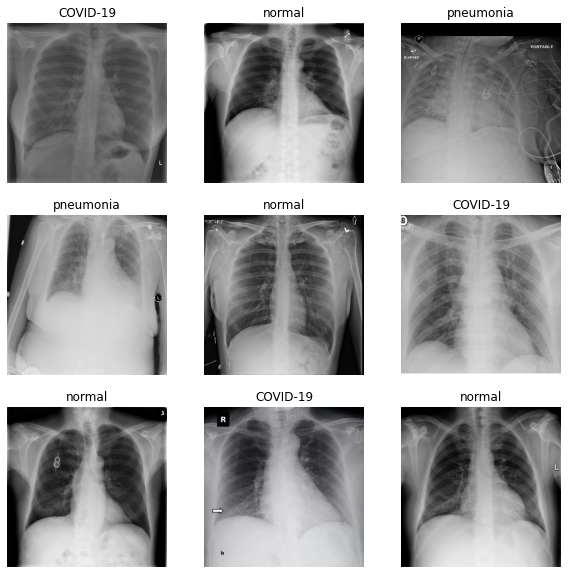

In [24]:
plt.figure(figsize=(10, 10))
for x_train_batch, y_train_batch in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(tf.cast(x_train_batch[i], tf.int32))
        plt.title(class_names[y_train_batch[i]])
        plt.axis('off')

### ResFPN Classifiers

In [25]:
import resnet, fpn, resnet_fpn

#### Without Pretrained ResNet Weights

In [26]:
ResFPN = resnet_fpn.ResFPN_Classifier(
    image_shape=IMAGE_SIZE + (3,), 
    num_classes=NUM_CLASSES, 
    num_filters=256, 
    architecture='resnet50', 
    augmentation=False,
    checkpoint_path=None,
    resnet_weights_path=None)

In [27]:
ResFPN.train(
    train_dataset=train_ds, 
    val_dataset=val_ds, 
    epochs=5, 
    lr=1e-2, 
    momentum=0.9, 
    l2=0.1, 
    save_weights=False)

Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
62/62 [==============================] - ETA: 0s - loss: 14.3963 - dense_resnet_loss: 1.4780 - dense_fpn_2_loss: 2.1547 - dense_fpn_3_loss: 2.1735 - dense_fpn_4_loss: 1.8910 - dense_fpn_5_loss: 1.3826 - dense_resnet_accuracy: 0.4744 - dense_fpn_2_accuracy: 0.4565 - dense_fpn_3_accuracy: 0.4571 - dense_fpn_4_accuracy: 0.4903 - dense_fpn_5_accuracy: 0.4744WARNING:tens

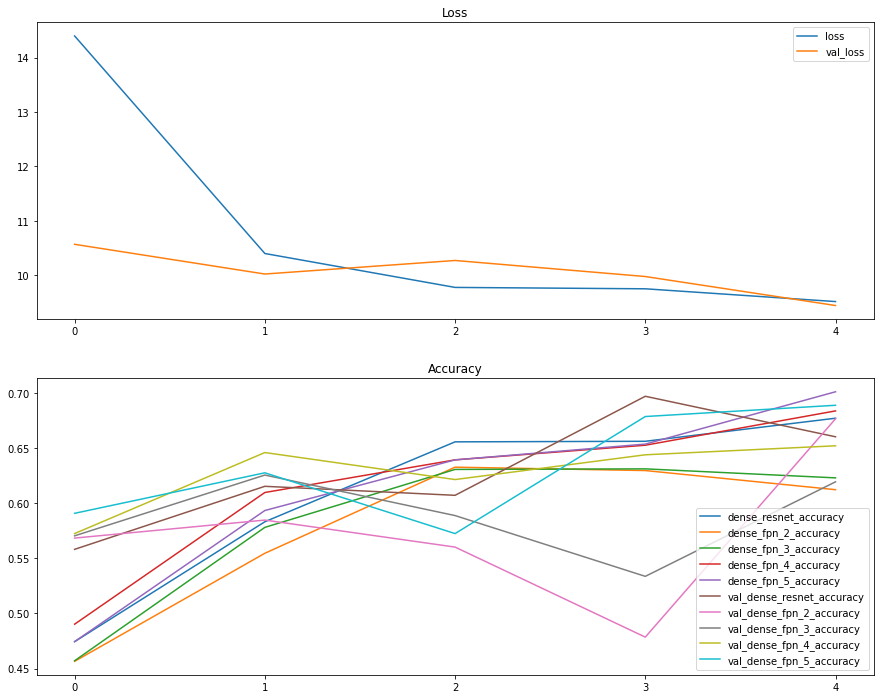

In [28]:
ResFPN.plot()

In [29]:
top_idxes, val_acc = ResFPN.select_top(val_ds, top=3)

16/16 [==============================] - 1s 93ms/step - loss: 9.4456 - dense_resnet_loss: 0.8923 - dense_fpn_2_loss: 0.8162 - dense_fpn_3_loss: 0.8831 - dense_fpn_4_loss: 0.7997 - dense_fpn_5_loss: 0.7379 - dense_resnet_accuracy: 0.6605 - dense_fpn_2_accuracy: 0.6769 - dense_fpn_3_accuracy: 0.6196 - dense_fpn_4_accuracy: 0.6524 - dense_fpn_5_accuracy: 0.6892
Top classifiers: ['res_fpn_4', 'resnet', 'res_fpn_3']
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a

In [30]:
ensemble_class_ids, metrics = ResFPN.predict(
    test_ds, CLASS_NAMES, display_metrics=True)

Test accuracy: 0.71

COVID-19:
  precision 0.12, recall 0.02, F1-score 0.03
normal:
  precision 0.87, recall 0.63, F1-score 0.72
pneumonia:
  precision 0.61, recall 0.80, F1-score 0.68

Average:
  precision 0.53, recall 0.48, F1-score 0.48


#### With Pretrained ResNet Weights

In [31]:
filepath = #'path\to\pretrained_resnet_weights.h5'

In [32]:
pretrain_ResFPN = resnet_fpn.ResFPN_Classifier(
    image_shape=IMAGE_SIZE + (3,), 
    num_classes=NUM_CLASSES, 
    num_filters=256, 
    architecture='resnet50', 
    augmentation=False,
    checkpoint_path=None,
    resnet_weights_path=filepath)

In [33]:
pretrain_ResFPN.train(
    train_dataset=train_ds, 
    val_dataset=val_ds, 
    epochs=5, 
    lr=1e-2, 
    momentum=0.9, 
    l2=0.1, 
    save_weights=False)

Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
62/62 [==============================] - ETA: 0s - loss: 16.2049 - dense_resnet_loss: 0.7468 - dense_fpn_2_loss: 1.7691 - dense_fpn_3_loss: 1.2755 - dense_fpn_4_loss: 1.0683 - dense_fpn_5_loss: 0.9086 - dense_resnet_accuracy: 0.7285 - dense_fpn_2_accuracy: 0.5813 - dense_fpn_3_accuracy: 0.6237 - dense_fpn_4_accuracy: 0.6697 - dense_fpn_5_accuracy: 0.7198WARNING:tens

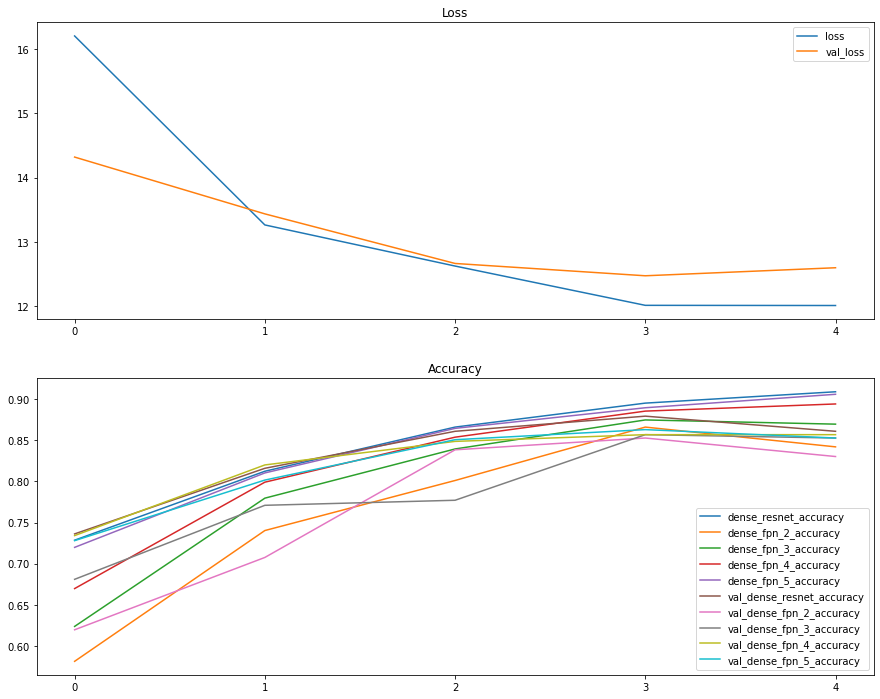

In [34]:
pretrain_ResFPN.plot()

In [35]:
top_idxes, val_acc = pretrain_ResFPN.select_top(val_ds, top=3)

16/16 [==============================] - 2s 95ms/step - loss: 12.5990 - dense_resnet_loss: 0.4038 - dense_fpn_2_loss: 0.5197 - dense_fpn_3_loss: 0.4673 - dense_fpn_4_loss: 0.3951 - dense_fpn_5_loss: 0.3765 - dense_resnet_accuracy: 0.8609 - dense_fpn_2_accuracy: 0.8303 - dense_fpn_3_accuracy: 0.8528 - dense_fpn_4_accuracy: 0.8569 - dense_fpn_5_accuracy: 0.8528
Top classifiers: ['res_fpn_3', 'res_fpn_4', 'res_fpn_2']
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @

In [36]:
ensemble_class_ids, metrics = pretrain_ResFPN.predict(
    test_ds, CLASS_NAMES, display_metrics=True)

Test accuracy: 0.89

COVID-19:
  precision 0.62, recall 0.29, F1-score 0.38
normal:
  precision 0.93, recall 0.87, F1-score 0.90
pneumonia:
  precision 0.84, recall 0.88, F1-score 0.85

Average:
  precision 0.80, recall 0.68, F1-score 0.71
